In [146]:
import numpy as np
import matplotlib.pyplot as plt

# Вариант 10: a = 350, b = 2, f0 = 110, n = 2

global a, b, f0
a = 350
b = 2
f0 = 110

def rosenbrock(x):
    x1, x2 = x
    return a * np.square(np.square(x1) - x2) + b * np.square(x1 - 1) + f0

def rosenbrock_gradient(x):
    x1, x2 = x
    grad_x1 = 4 * a * x1 * (np.square(x1) - x2) + 2 * b * (x1 - 1)
    grad_x2 = - 2 * a * (np.square(x1) - x2)
    return np.array([grad_x1, grad_x2])

def hesse(x):
    x1, x2 = x
    # grad_x1 = 4 * a * x1 * (np.square(x1) - x2) + 2 * b * (x1 - 1) = 4ax1^3 - 4ax1x2 + 2bx1 - 2b
    # grad_x2 = - 2 * a * (np.square(x1) - x2) = -2ax1^2 + 2ax2
    h11 = 12 * a * np.square(x1) - 4 * a * x2 + 2 * b
    h12 = -4 * a * x1
    h21 = -4 * a * x1
    h22 = 2 * a
    return np.array([[h11, h12],
                    [h21, h22]])

In [147]:
def golden_section_search(f, a, b, tol=1e-6):
    phi = (1 + np.sqrt(5)) / 2
    c = b - (b - a) / phi
    d = a + (b - a) / phi

    while abs(b - a) > tol:
        if f(c) < f(d):
            b = d
        else:
            a = c

        c = b - (b - a) / phi
        d = a + (b - a) / phi


    return (a + b) / 2

In [148]:
# Fletcher-Reeves
def fr(x0, f, gradient, tol=1e-4, max_iter=100):
    epsilon = 0.001
    x = x0.copy()
    hist_x = [x]
    hist_f = [f(x)]
    d = -gradient(x)
    for _ in range(max_iter):
        alpha = golden_section_search(lambda a: f(x + a * d), 0, 1)
        x_new = x + alpha * d
        hist_x.append(x_new)
        hist_f.append(f(x_new))

        if np.linalg.norm(x_new - x) < tol:
            return x_new, hist_x, hist_f
        
        w = np.dot(gradient(x_new) - epsilon, gradient(x_new)) / np.square(np.linalg.norm(gradient(x)))
        d = -gradient(x_new) + w * d
        x = x_new

    return x, hist_x, hist_f

# Polak-Ribiere
def pr(x0, f, gradient, tol=1e-4, max_iter=100):
    x = x0.copy()
    hist_x = [x]
    hist_f = [f(x)]
    d = -gradient(x)

    for _ in range(max_iter):
        alpha = golden_section_search(lambda a: f(x + a * d), 0, 1)
        x_new = x + alpha * d
        hist_x.append(x_new)
        hist_f.append(f(x_new))

        if np.linalg.norm(x_new - x) < tol:
            return x_new, hist_x, hist_f

        w = max(0, np.dot(gradient(x_new) - gradient(x), gradient(x_new)) / np.square(np.linalg.norm(gradient(x))))
        d = -gradient(x_new) + w * d
        x = x_new

    return x, hist_x, hist_f

# Davidon-Fletcher-Powell
def dfp(x0, f, gradient, tol=1e-4, max_iter=100):
    x = x0.copy()
    hist_x = [x]
    hist_f = [f(x)]
    H = np.eye(len(x0))

    for _ in range(max_iter):
        d = -H @ gradient(x)
        alpha = golden_section_search(lambda a: f(x + a * d), 0, 1)
        p = alpha * d
        x_new = x + p
        hist_x.append(x_new)
        hist_f.append(f(x_new))

        if np.linalg.norm(x_new - x) < tol:
            return x_new, hist_x, hist_f

        dg = gradient(x_new) - gradient(x)
        s = 1 / np.dot(dg, p)

        H = (np.eye(len(x0)) - s * np.outer(p, dg)) @ H @ (np.eye(len(x0)) - s * np.outer(dg, p)) + s * np.outer(p, p)
        x = x_new

    return x, hist_x, hist_f
    

# Levenberg-Marquardt
def lm(x0, f, gradient, tol=1e-4, max_iter=100, mu=10000):
    x = x0.copy()
    hist_x = [x]
    hist_f = [f(x)]

    for _ in range(max_iter):
        d = -np.linalg.pinv(np.diag(np.ones(len(x0)) * mu) + hesse(x)) @ gradient(x)
        alpha = golden_section_search(lambda a: f(x + a * d), 0, 1)
        p = alpha * d
        x_new = x + p
        hist_x.append(x_new)
        hist_f.append(f(x_new))

        if np.linalg.norm(x_new - x) < tol:
            return x_new, hist_x, hist_f

        if f(x_new) < f(x):
            mu = mu / 2
            x = x_new
        else:
            mu = mu * 2

    return x, hist_x, hist_f


In [149]:
x0 = np.array([0.06, 0.08])

x_min_fr, hist_x_fr, hist_f_fr = fr(x0, rosenbrock, rosenbrock_gradient)
x_min_pr, hist_x_pr, hist_f_pr = pr(x0, rosenbrock, rosenbrock_gradient)
x_min_dfp, hist_x_dfp, hist_f_dfp = dfp(x0, rosenbrock, rosenbrock_gradient)
x_min_lm, hist_x_lm, hist_f_lm = lm(x0, rosenbrock, rosenbrock_gradient)

print(f"Fletcher-Reeves method result: {x_min_fr}, min value: {rosenbrock(x_min_fr)}, № of iterations: {len(hist_f_fr)}, Relative error: {(rosenbrock(x_min_fr)-f0)/f0*100}")
print(f"Polak-Ribiere method result: {x_min_pr}, min value: {rosenbrock(x_min_pr)}, № of iterations: {len(hist_f_pr)}, Relative error: {(rosenbrock(x_min_pr)-f0)/f0*100}")
print(f"Davidon-Fletcher-Powell result: {x_min_dfp}, min value: {rosenbrock(x_min_dfp)}, № of iterations: {len(hist_f_dfp)}, Relative error: {(rosenbrock(x_min_dfp)-f0)/f0*100}")
print(f"Levenberg-Marquardt method result: {x_min_lm}, min value: {rosenbrock(x_min_lm)}, № of iterations: {len(hist_f_lm)}, Relative error: {(rosenbrock(x_min_lm)-f0)/f0*100}")

Fletcher-Reeves method result: [0.99932332 0.99864526], min value: 110.00000091696982, № of iterations: 13, Relative error: 8.33608931378132e-07
Polak-Ribiere method result: [0.994174   0.98836972], min value: 110.00006793681291, № of iterations: 6, Relative error: 6.176073901025865e-05
Davidon-Fletcher-Powell result: [0.99999998 0.99999995], min value: 110.0, № of iterations: 24, Relative error: 0.0
Levenberg-Marquardt method result: [0.99999985 0.9999997 ], min value: 110.00000000000004, № of iterations: 24, Relative error: 3.875687649600546e-14


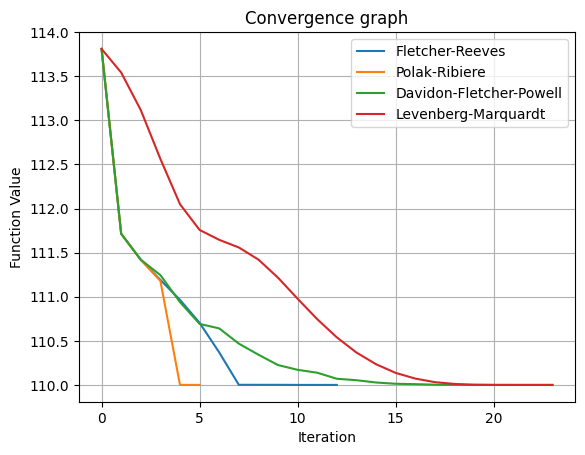

In [150]:
plt.plot(range(len(hist_f_fr)), hist_f_fr, label='Fletcher-Reeves')
plt.plot(range(len(hist_f_pr)), hist_f_pr, label='Polak-Ribiere')
plt.plot(range(len(hist_f_dfp)), hist_f_dfp, label='Davidon-Fletcher-Powell')
plt.plot(range(len(hist_f_lm)), hist_f_lm, label='Levenberg-Marquardt')

plt.xlabel('Iteration')
plt.ylabel('Function Value')
plt.title('Convergence graph')
plt.legend()

# Displaying the plot
plt.grid(True)
plt.show()